# Librerías

In [1]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Limpieza de archivos

In [3]:
def limpiar_archivos_corruptos(path, format='.jpeg'):
  for filename in os.listdir(path):
    if filename.endswith(format):
      try:
        img = Image.open(os.path.join(path,filename)) # open the image file
        img.verify() # verify that it is, in fact an image
      except:
        os.remove(os.path.join(path,filename))
        print('Removiendo archivo corrupto:', filename) # print out the names of corrupt files

In [4]:
limpiar_archivos_corruptos("X-Ray-Pneumonia-Images/Images")

In [5]:
# Cuenta en número de imágenes
def contar_imagenes(path):
  return sum([len(files) for r, d, files in os.walk(path)])

print("Número de imágenes en el dataset:", contar_imagenes("X-Ray-Pneumonia-Images/Images"))

Número de imágenes en el dataset: 5856


# Lectura de datos

In [6]:
train_df = pd.read_csv('train.csv', index_col=0)
train_df.head()


,File_names,Target
Id,,
0,e184d851-45d7-50ff-85a9-9b75993484e7.jpeg,0
1,6e2c95c7-c0c2-565a-b3e2-d9de6eeb72ce.jpeg,1
2,2b7ca495-6101-5fe1-9c35-3a37e98a0cf2.jpeg,1
3,9d5fdc1a-22ac-5a4b-9942-694fa403765c.jpeg,1
4,786806b0-55cd-5aa3-a5d8-66701ffd77f7.jpeg,1


In [7]:
# Columnas de la data
train_df.columns

Index(['File_names', 'Target'], dtype='object')

In [8]:
train_df.shape

(4977, 2)

In [9]:
train_df['Target'].value_counts()

Target
1    3632
0    1345
Name: count, dtype: int64

# Carga de imagenes

In [10]:
# Crea una carpeta llamada Imagenes con subcarpetas para cada clase
os.makedirs('Imagenes', exist_ok=True)
os.makedirs('Imagenes/yes', exist_ok=True)
os.makedirs('Imagenes/no', exist_ok=True)


In [11]:
# Copia las imágenes a las carpetas correspondientes
for index, row in tqdm(train_df.iterrows()):
    img = imread(f'X-Ray-Pneumonia-Images/Images/{row["File_names"]}')
    if row['Target'] == 1:
        plt.imsave(f'Imagenes/yes/{row["File_names"]}', img)
    else:
        plt.imsave(f'Imagenes/no/{row["File_names"]}', img)

4977it [02:51, 28.97it/s]


In [12]:
path = 'Imagenes'

img_size = 224
batch_size = 32 # 64

In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

""" train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
) """

' train_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=20,\n    zoom_range=0.15,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.15,\n    horizontal_flip=True,\n    fill_mode="nearest"\n) '

In [14]:
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size)

Found 4977 images belonging to 2 classes.


In [15]:
train_generator.class_indices

{'no': 0, 'yes': 1}

yes/cedf953e-17f5-5977-a858-85c76edeae9b.jpeg


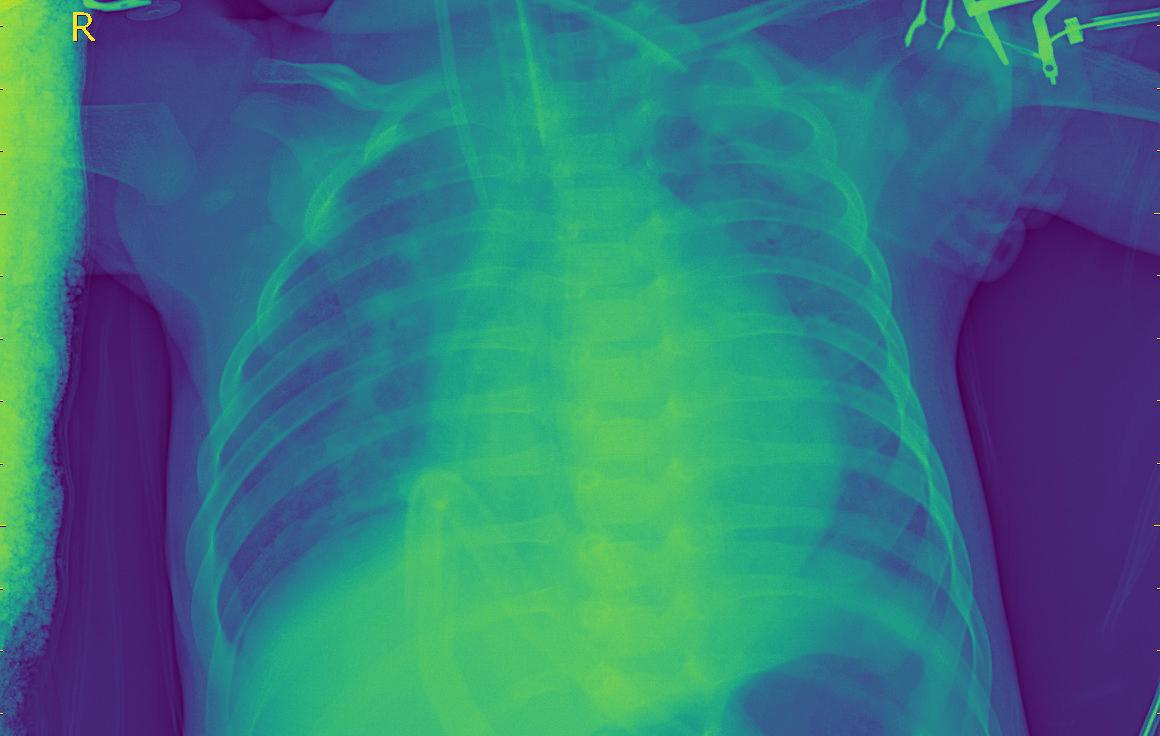

In [16]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + '/' + random_img)

# Definición de modelos base

Propuesta de modelos preentrenados:
 - ResNet50
 - InceptionV3
 - DenseNet121

## Red preentrenada de ResNet50

In [17]:
# Carga el modelo ResNet50
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling='avg')
base_model_resnet.trainable = False
base_model_resnet.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [18]:
cls_model = Sequential()

cls_model.add(Dense(512, activation='relu', input_shape=base_model_resnet.output_shape[1:]))
cls_model.add(Dense(train_generator.num_classes, activation='softmax'))

cls_model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cls_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 1050114 (4.01 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
final_model_resnet = Sequential()
final_model_resnet.add(base_model_resnet)
final_model_resnet.add(cls_model)

final_model_resnet.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

final_model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential (Sequential)     (None, 2)                 1050114   
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [20]:
train_generator2 = train_datagen.flow_from_directory(
    path, target_size=(img_size, img_size), batch_size=batch_size, shuffle=False
)

Found 4977 images belonging to 2 classes.


In [21]:
n_batches = math.ceil(train_generator2.samples / batch_size)
n_batches

156

In [41]:
train_generator2.reset()

# Variables donde vamos a guardar los features extraidos
outputs_x = []
outputs_y = []

for i in tqdm(range(n_batches)):
    x, y = next(train_generator2)
    outputs_x.append(base_model_resnet.predict_on_batch(x)) #base_model_resnet.predict(x)
    outputs_y.append(y)

outputs_x = np.concatenate(outputs_x)
outputs_y = np.concatenate(outputs_y)

100%|██████████| 156/156 [02:05<00:00,  1.24it/s]


In [42]:
outputs_x.shape, outputs_y.shape

((4977, 2048), (4977, 2))

In [43]:
# Guardamos los arrays
np.savez_compressed('Imagenes/no_yes_precomputed', x=outputs_x, y=outputs_y)

In [44]:
# Cargar arrays
data = np.load('Imagenes/no_yes_precomputed.npz')
outputs_x = data['x']
outputs_y = data['y']

outputs_x.shape, outputs_y.shape

((4977, 2048), (4977, 2))

In [45]:
outputs_x.shape

(4977, 2048)

In [46]:
log = cls_model.fit(
    outputs_x, outputs_y,
    epochs=10,
    batch_size=batch_size,
    #validation_split=0.2
)


Epoch 1/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0361 - accuracy: 0.9873
Epoch 2/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0445 - accuracy: 0.9829
Epoch 3/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0344 - accuracy: 0.9869
Epoch 4/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0332 - accuracy: 0.9885
Epoch 5/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0342 - accuracy: 0.9859
Epoch 6/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0266 - accuracy: 0.9887
Epoch 7/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0268 - accuracy: 0.9902
Epoch 8/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0319 - accuracy: 0.9879
Epoch 9/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0183 - accuracy: 0.9934
Epoch 10/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0255 - accuracy: 0.9912

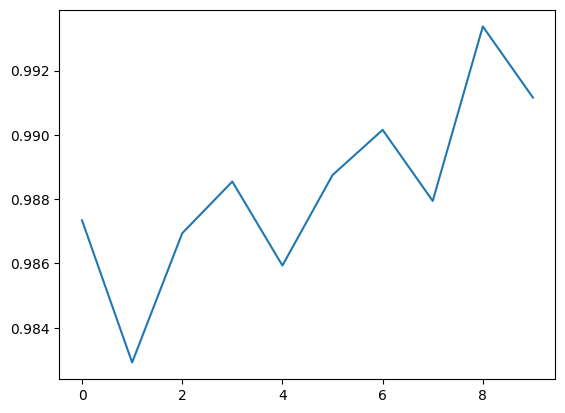

In [47]:
# Show the learning curves
plt.plot(log.history['accuracy'], label='accuracy')

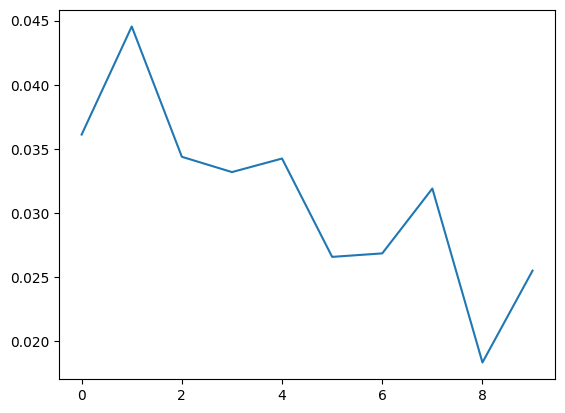

In [48]:
# Show loss
plt.plot(log.history['loss'], label='loss')

In [67]:
lbl_dict = {v: k for k, v in train_generator.class_indices.items()}

def get_class(img_path):

    # Cargar la imagen del path
    img = Image.open(img_path).convert('RGB')

    # Resize
    img_resized = img.resize((img_size, img_size))

    # Convertir a array
    x = np.asarray(img_resized, np.float32)[None]
    x = preprocess_input(x)

    # Obtener predicciones
    y = final_model_resnet.predict(x)

    # Decodear las predicciones
    pred = lbl_dict[np.argmax(y)]

    return pred

def get_probabilities(img_path):

    # Cargar la imagen del path
    img = Image.open(img_path).convert('RGB')

    # Resize
    img_resized = img.resize((img_size, img_size))

    # Convertir a array
    x = np.asarray(img_resized, np.float32)[None]
    x = preprocess_input(x)

    # Obtener predicciones
    probabilities = final_model_resnet.predict(x)
    probabilities = 1 - probabilities
    formatted_probability = f"{probabilities[0][0]:.16f}"
    return formatted_probability

# Submission

In [68]:
# Crea un dataframe con las predicciones en base a test_x.csv

test_df = pd.read_csv('test_x.csv')
test_df.head()


,Id,File_names
0,0,1a8e3b37-63d9-5fbc-ac08-1575de9ca7b3.jpeg
1,1,c802f47b-126d-54da-8560-af9fc64594c0.jpeg
2,2,72cf7ea5-294a-5af3-8e75-4cddd685e9c7.jpeg
3,3,79080b42-3598-5418-930e-c6c29f59bf33.jpeg
4,4,57b2427f-dd56-5d1e-b5ad-84459c5a658a.jpeg


In [69]:
img_path = f'X-Ray-Pneumonia-Images/Images/{test_df["File_names"][0]}'
img = Image.open(img_path).convert('RGB')

# Show size of img
print(img.size)


(1310, 928)


In [70]:
# Genera las predicciones para el dataframe
test_df['Target'] = test_df['File_names'].apply(lambda x: get_probabilities(f'X-Ray-Pneumonia-Images/Images/{x}'))

1/1 [==============================] - 0s 76ms/step


In [72]:
output = pd.DataFrame({
    'Id' : test_df['Id'],
    'Predicted' : test_df['Target']
})

output.to_csv('submission.csv' ,index=False)